In [34]:
import os
import pandas as pd
import cv2

DIR = "data/fungi_train_val"
directories = []

folders = os.listdir(DIR)

for folder in folders:
    photos = os.listdir(DIR + "/" + folder)
    cat = ' '.join(folder.split('_')[1:])
    super_cat = folder.split('_')[1]
    for photo in photos:
        path = DIR + "/" + folder + "/" + photo
        directories.append({
            'super_category': super_cat, 
            'category': cat, 
            'path': path
        })
        
df = pd.DataFrame(directories)
df

,super_category,category,path
0,Cortinarius,Cortinarius uliginosus f. uliginosus,data/fungi_train_val/12665_Cortinarius_uligino...
1,Cortinarius,Cortinarius uliginosus f. uliginosus,data/fungi_train_val/12665_Cortinarius_uligino...
2,Cortinarius,Cortinarius uliginosus f. uliginosus,data/fungi_train_val/12665_Cortinarius_uligino...
3,Cortinarius,Cortinarius uliginosus f. uliginosus,data/fungi_train_val/12665_Cortinarius_uligino...
4,Cortinarius,Cortinarius uliginosus f. uliginosus,data/fungi_train_val/12665_Cortinarius_uligino...
...,...,...,...
89755,Cheilymenia,Cheilymenia granulata,data/fungi_train_val/12195_Cheilymenia_granula...
89756,Cheilymenia,Cheilymenia granulata,data/fungi_train_val/12195_Cheilymenia_granula...
89757,Cheilymenia,Cheilymenia granulata,data/fungi_train_val/12195_Cheilymenia_granula...
89758,Cheilymenia,Cheilymenia granulata,data/fungi_train_val/12195_Cheilymenia_granula...


In [205]:
df_sorted = df.groupby(['super_category']).count().rename(columns={'path':'count'})[['count']].sort_values(by='count', ascending=False)
df_sorted

,count
super_category,
Russula,4346
Cortinarius,4313
Mycena,3958
Lactarius,2310
Hygrocybe,2161
...,...
Phragmidium,7
Trichopeziza,7
Chamaemyces,6


In [214]:
reference = 'super_category'
n_classes = 3
samples_per_class = 200
training_size_ratio = 0.9

classes = df[reference].drop_duplicates()
df1 = pd.DataFrame()
for i, v in df_sorted.iloc[:n_classes].iterrows():
    size = min(int(training_size_ratio*samples_per_class), df.loc[df[reference] == i].shape[0])
    training_size = int(size*training_size_ratio)
    tmp_df = df.loc[df[reference] == i].iloc[:training_size]
    tmp_df['training'] = 1
    df1 = df1.append(tmp_df)
    tmp_df = df.loc[df[reference] == i].iloc[training_size:samples_per_class]
    tmp_df['training'] = 0
    df1 = df1.append(tmp_df)
    
df1.head()

,super_category,category,path,training
50,Russula,Russula fellea,data/fungi_train_val/19970_Russula_fellea/PTP2...,1
51,Russula,Russula fellea,data/fungi_train_val/19970_Russula_fellea/TS20...,1
52,Russula,Russula fellea,data/fungi_train_val/19970_Russula_fellea/PEL2...,1
53,Russula,Russula fellea,data/fungi_train_val/19970_Russula_fellea/TS20...,1
54,Russula,Russula fellea,data/fungi_train_val/19970_Russula_fellea/TS20...,1


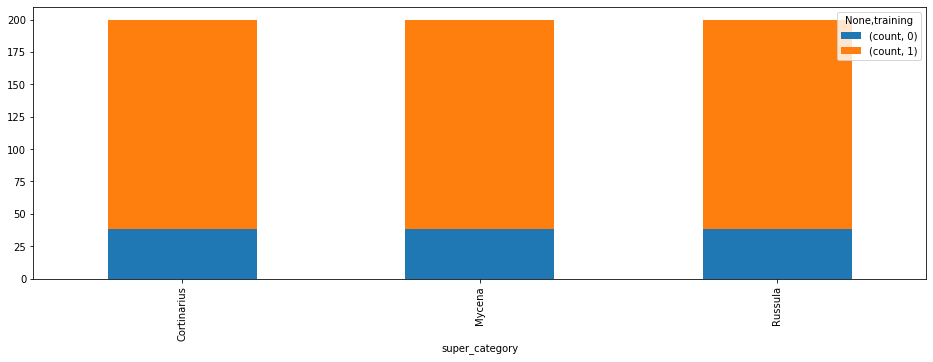

In [215]:
import pandas as pd

df_count = df1.groupby(['super_category','training']).count().rename(columns={'path':'count'})[['count']]
df_count = df_count.unstack('training')
df_count.plot(kind='bar', stacked=True, figsize=(16,5))

In [217]:
df_training = df1.loc[df1['training'] == 1]
df_validation = df1.loc[df1['training'] == 0]

print("Training set:", df_training.shape[0])
print("Validation set:", df_validation.shape[0])

Training set: 486
Validation set: 114


In [218]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

DIR = os.getcwd()
training_datagen = ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    fill_mode='nearest'
)

img_size = 150

train_generator = training_datagen.flow_from_dataframe(
    df_training,
    DIR,
    'path',
    'super_category',
    target_size=(img_size, img_size),
    class_mode='categorical'
)

Found 486 validated image filenames belonging to 3 classes.


In [219]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    df_validation,
    DIR,
    'path',
    'super_category',
    target_size=(img_size, img_size),
    class_mode='categorical'
)

Found 114 validated image filenames belonging to 3 classes.


In [220]:
classes = []

for i in train_generator.class_indices:
    classes.append(i)

print(classes, len(classes))

['Cortinarius', 'Mycena', 'Russula'] 3


In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model('models/model_5classes_45acc_100x100img.h5')

In [222]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # Hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(classes), activation='softmax')
])

In [223]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

In [109]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten

# VGG16
model = tf.keras.models.Sequential([
    Conv2D(input_shape=(img_size,img_size,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"),
    Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Flatten(),
    Dense(units=4096,activation="relu"),
    Dense(units=4096,activation="relu"),
    Dense(units=n_categories, activation="softmax")
])

In [110]:
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.01)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [158]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 15, 15, 128)      

In [224]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
history = model.fit(train_generator, epochs=100,
            validation_data = validation_generator,
            verbose=1, callbacks=[es])

model.save('model.h5')

Epoch 1/100
16/16 [==============================] - 24s 1s/step - loss: 1.4570 - accuracy: 0.3354 - val_loss: 1.0970 - val_accuracy: 0.3860
Epoch 2/100
16/16 [==============================] - 22s 1s/step - loss: 1.0986 - accuracy: 0.3416 - val_loss: 1.1031 - val_accuracy: 0.3333
Epoch 3/100
16/16 [==============================] - 22s 1s/step - loss: 1.0999 - accuracy: 0.3765 - val_loss: 1.0933 - val_accuracy: 0.3333
Epoch 4/100
16/16 [==============================] - 22s 1s/step - loss: 1.1174 - accuracy: 0.3848 - val_loss: 1.0944 - val_accuracy: 0.3333
Epoch 5/100
16/16 [==============================] - 23s 1s/step - loss: 1.0848 - accuracy: 0.3951 - val_loss: 1.0842 - val_accuracy: 0.3860
Epoch 6/100
16/16 [==============================] - 22s 1s/step - loss: 1.1106 - accuracy: 0.3827 - val_loss: 1.0935 - val_accuracy: 0.3421
Epoch 7/100
16/16 [==============================] - 22s 1s/step - loss: 1.0633 - accuracy: 0.4239 - val_loss: 1.0704 - val_accuracy: 0.4211
Epoch 8/100
1

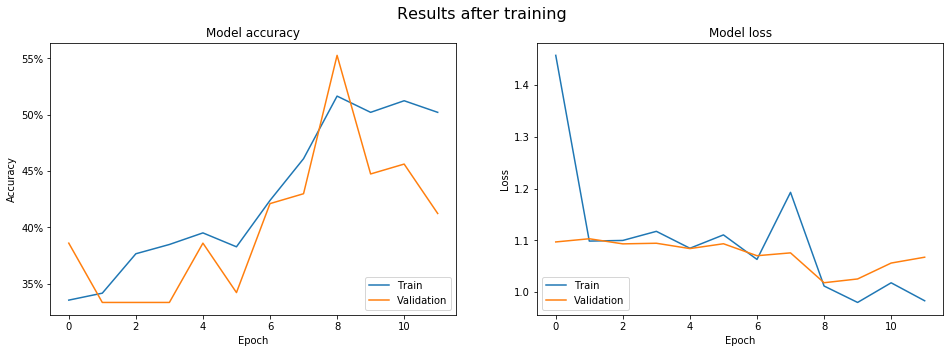

In [225]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

fig, axes = plt.subplots(1, 2, figsize=(16,5))
fig.suptitle('Results after training', fontsize=16)

# summarize history for accuracy
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='lower right')

# summarize history for loss
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='lower left')

plt.show()

In [226]:
val_loss, val_acc = model.evaluate(validation_generator)

4/4 [==============================] - 1s 229ms/step - loss: 1.0675 - accuracy: 0.4123


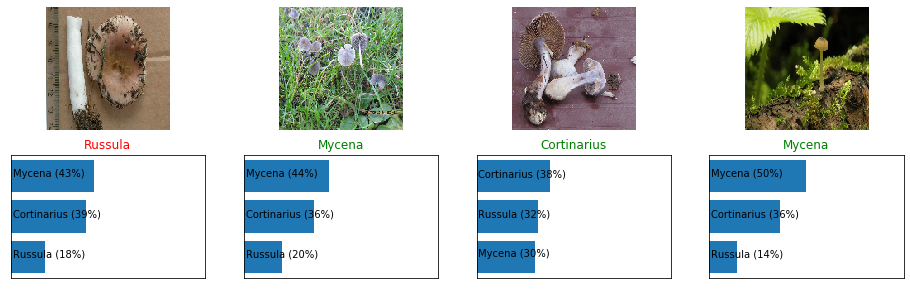

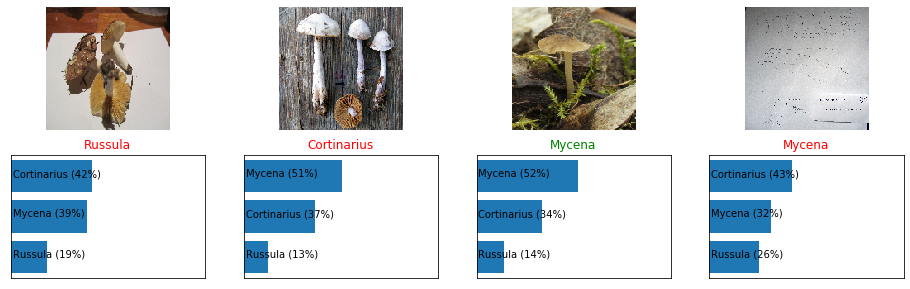

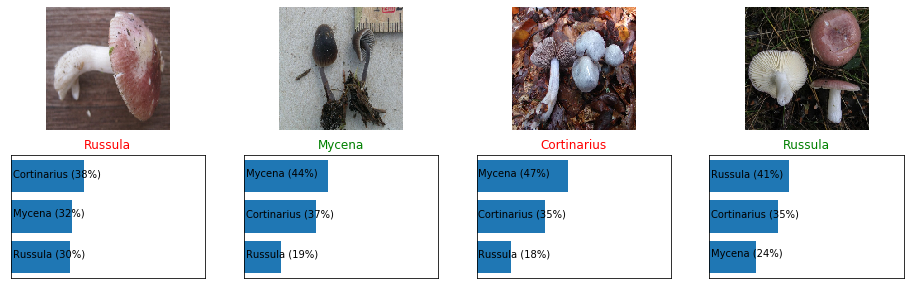

In [227]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.ticker import FuncFormatter
import numpy as np

iters = 0
n_predictions = 8
n_cols = 4
    
for i, batch in enumerate(validation_generator):
    if iters > n_predictions:
        break
    
    batch_images, batch_labels = batch
    
    for j in range(len(batch_images)):
        if iters > n_predictions:
            break
            
        fig, axes = plt.subplots(2, n_cols, figsize=(16,5))
        
        for k in range(n_cols):
            prediction = model.predict(np.array([batch_images[j*n_cols+k]]))
            res = [{'label': classes[h], 'val': prediction[0][h]} for h in range(len(classes))]
            res.sort(key=lambda x: x['val'], reverse=True)
            res = res[0:5]
            axes[0][k].imshow(batch_images[j*n_cols+k])
            axes[0][k].grid(False)
            axes[0][k].axis('off')
            title_color = 'green'
            if np.argmax(batch_labels[j*n_cols+k]) != np.argmax(prediction[0]):
                title_color = 'red'
            axes[1][k].set_title(classes[np.argmax(batch_labels[j*n_cols+k])], color=title_color)
            axes[1][k].barh([x['label'] for x in res], [x['val'] for x in res])
            axes[1][k].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
            axes[1][k].set_xlim(0, 1)
            axes[1][k].invert_yaxis()
            axes[1][k].set_xticks([])
            axes[1][k].set_yticks([])
            for h, v in enumerate(res):
                axes[1][k].text(0.01, h, '{} ({:.0%})'.format(v['label'], v['val']))
                
            iters += 1

        plt.show()